Load the dataset from sklearn

In [2]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Let's learn more about the data...

In [3]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

The data consists of two important keys: data and target. 
Data - contains an array with one row per instance and one column per feature
Target - contains an array with the labels (we're classifying information so labels are really important)

In [4]:
data, labels = mnist['data'], mnist['target']

Let's see what shapes we're dealing with...

In [5]:
data.shape

(70000, 784)

In [6]:
labels.shape

(70000,)

Let's look at one digit from the dataset. Each image has 784 features - 28x28. Let's grab and image's data, reshape it, and then display it. 

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
digit = data[0]
digit_image = digit.reshape(28,28)
plt.imshow(digit_image, cmap='binary')
plt.axis('off')
plt.show()

KeyError: 0

In [7]:
labels[0]

'5'

The image kind of looks like a 5, and sure enough it is labeled as a 5. Because ML algorithms usually expect numbers, we should cast the labels as numbers.

In [8]:
import numpy as np
labels = labels.astype(np.uint8)

Before we start doing any manipulations, we should create our training set and test set. What does the description have to say about the dataset in regards to training/test?

In [10]:
data_train, data_test, labels_train, labels_test = data[:60000], data[60000:], labels[:60000], labels[60000:]

Break of the data based on fives and not fives

In [11]:
labels_train_5 = (labels_train == 5)
labels_test_5 = (labels_test == 5)

Back to notes...

Let's use a Stochastic Gradient Descent algorithm to train on identifying fives

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 21)

Why random_state = 21?

In [13]:
sgd_clf.fit(data_train, labels_train_5)

SGDClassifier(random_state=21)

Model is trained...now, we can use it to predict the value of a digit

In [14]:
sgd_clf.predict([digit])

array([ True])

This value was a five if you remember from before so we received what we expected. 
Back to notes...

In [15]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, data_train, labels_train_5, cv = 3, scoring = 'accuracy')

array([0.9649, 0.9674, 0.9583])

Wow! Well done!!! Let's call it a day!

Just kidding. We need to rethink this. Is Accuracy a valid metric for evaluating this model?

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, data, labels=None):
        return self
    def predict(self, data):
        return np.zeros((len(data), 1), dtype = bool)

In [17]:
never_5_clf = Never5Classifier()

In [18]:
cross_val_score(never_5_clf, data_train, labels_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

No, accuracy is not a good evaluator. What the above shows is that basically, only about 10% of the images are fives meaning that if you guessed an image was not a five, you would be right 90% of the time. It doesn't really give us a good idea of how accurate our model is. Let's evaluate a different way using a Confusion Matrix.

In [22]:
from sklearn.model_selection import cross_val_predict
labels_train_predict = cross_val_predict(sgd_clf, data_train, labels_train_5, cv = 3)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_train_5, labels_train_predict)

array([[53875,   704],
       [ 1484,  3937]])

The above confusion matrix shows us how often the model was "confused." The first row is dealing with the negative class, the not a five class. The model accurately identified 53,875 not-5's as not a 5 (true negatives); however, it thought 704 images were fives, but they weren't (false positives - falsely identified as a positive result). It accurately identified 3,937 fives as fives (true positives), but it misidentified 1,484 fives as not fives (false negatives).  

Let's use sklearn to get the precision and recall scores

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(labels_train_5, labels_train_predict)

0.8483085541909071

In [45]:
recall_score(labels_train_5, labels_train_predict)

0.726249769415237

Get the F-measure/F-score

In [46]:
from sklearn.metrics import f1_score
f1_score(labels_train_5, labels_train_predict)

0.7825482011528523

We can change the threshold to increase/decrease precision/recall

In [49]:
labelsScores = sgd_clf.decision_function([digit])
threshold = 8000
labelsDigitPred = (labelsScores > threshold)
labelsDigitPred

array([False])

Decide on the threshold

In [52]:
labelsScores = cross_val_predict(sgd_clf, 
                                 data_train,
                                 labels_train_5, 
                                 cv=3, 
                                 method='decision_function')

We can use these scores with precision/recall to plot what the results would be with different thresholds

In [53]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = 
precision_recall_curve(labels_train_5, labelsScores)

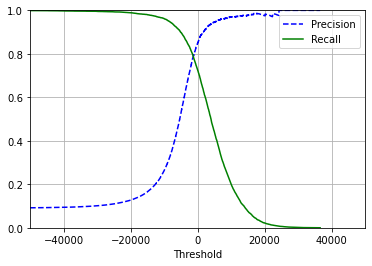

In [55]:
def plotPrecisionRecallThreshold(pre, rec, thr):
    plt.plot(thr, pre[:-1], 'b--', 
             label='Precision')
    plt.plot(thr, rec[:-1], 'g-', label='Recall')
    plt.grid()
    plt.xlabel('Threshold')
    plt.legend()
    plt.axis([-50000,50000,0,1])

plotPrecisionRecallThreshold(precisions, recalls,
                            thresholds)
plt.show()

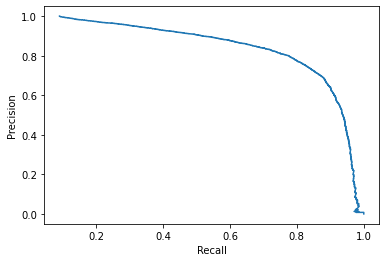

In [58]:
plt.plot(precisions, recalls)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

90% precision is what we want

In [59]:
threshold90Precision = thresholds[np.argmax(precisions>=.90)]
threshold90Precision

1568.168734996127

In [60]:
labelsTrainPred90 = (labelsScores >= threshold90Precision)
labelsTrainPred90

array([ True, False, False, ...,  True, False, False])

In [61]:
precision_score(labels_train_5, labelsTrainPred90)

0.9

In [62]:
recall_score(labels_train_5, labelsTrainPred90)

0.6425013835085778

Multiclass Classification

In [1]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(data_train, labels_train)
svm_clf.predict([digit])

NameError: name 'data_train' is not defined

In [ ]:
digitScores = svm_clf.decision_function([digit])
digitScores

In [65]:
sgd_clf.fit(data_train, labels_train)
sgd_clf.predict([digit])

array([5], dtype=uint8)

In [66]:
sgd_clf.decision_function([digit])

array([[-18196.9520904 , -31244.71856718,  -4213.59891629,
           326.92094366, -24136.29632266,   1692.30287684,
        -25540.36656062, -16171.57393161,  -9403.41394604,
        -12758.76458728]])